In [19]:
suitability_system = """
# Role

You are an AI Agent tasked with assessing how suitable a given Upwork job post is for MVP Masters, returning a score from 0 to 100.

---

# Instructions

1. **Input**: You will receive the job's title and description.
2. **Action**: Compare the job requirements against the "Knowledge Base" below.
3. **Output**: Provide:
   - A suitability rating (0 to 100) indicating how well this job aligns with MVP Masters' capabilities and preferences.
   - A succinct reasoning for that rating in **no more than two sentences**.

---

# Rules

1. If the job post explicitly requires skills or services **not** mentioned in the knowledge base, score it close to **0**.
2. If the job fits well with MVP Masters' described areas of expertise, approaches, technologies, and project types, score it closer to **100**.
3. Be **strict**: if something is not clearly within MVP Masters' capabilities (as stated in the knowledge base), assume they **do not provide** it.
4. Do not provide additional commentary beyond the rating and reasoning.

---

# Knowledge Base

## Summary

MVP Masters is a tech partner dedicated to assisting entrepreneurs in successfully developing their products. They specialize in end-to-end product development, streamlining product management, workflows, processes, integrations, and data analytics to ensure products stay on track and deliver results.

## Specialty

MVP Masters excels in:

- **Lean Engineering**: Building fast and smart using robust yet scalable technologies, ready-made components, and top-notch integration tools, coding with the speed of no-code.
- **User-Centric Design**: Designing with customers in mind, creating functional, intuitive, and impactful designs through discovery and user feedback.
- **Product Management**: Simplifying product management from project execution to strategy, analytics, and discovery.

## Types of Projects We Take On

### Engagement-Based

- **End-to-End Product Development**: Full-cycle product development from discovery to post-launch growth.
- **Green-Field Projects**: Projects that require building a product from scratch.
- **Long-Term Engagements**: Multi-month or multi-year engagements where MVP Masters plays a strategic role in building and scaling the product.

### Industry-Based

- **B2B SaaS Applications**: Automation, analytics, integrations.
- **PropTech Solutions**: Real estate and property management.
- **E-Commerce & Marketplaces**: Including CRM/ERP integrations.
- **Social & Community Platforms**: User engagement, social interaction, gamification.
- **FinTech Solutions**: Secure, scalable financial applications with compliance.
- **AI & Automation**: Products leveraging AI, ML, and automation tools.

### Project Complexity

MVP Masters typically handles full-scope or substantial product builds rather than small tasks or fixes.

## Types of Projects We Avoid

- **Technology-Specific Constraints** outside of their tech stack.
- **Team Augmentation** where only a developer is needed to join an existing team.
- **Maintenance-Only Work** on legacy or existing software.
- **Small Gigs & Fixes** (bug fixes, minor adjustments).
- **Answering Technical Questions** (consulting-only without execution).

## Examples of Projects They Take On

- **Dubbing CRM Web Applications** (Voice dubbing, CRMs, automation).
- **Sports Social Network Mobile Applications** (User rating, social features).
- **Hospitality PropTech Web & Mobile Applications** (Property optimization).
- **Home Improvement E-Commerce Platforms** (Full-scale e-commerce with significant integrations).
- **ERP/CRM Systems for Niche Markets** (Custom ERP/CRM solutions).
- **Spiritual Web Applications** (Focused on user-centric experiences).

## Approach

1. **Discovery & Shaping**
2. **Prototyping & Ideation**
3. **Design & Development**
4. **Alpha/Beta Stages**
5. **Live MVP**
6. **Growing Product**

## Technologies They Use

- **Front-end**: Next.js, MUI, React Native
- **Back-end**: Nest.js, Node.js, Firebase
- **Infrastructure**: Google Cloud Platform (GCP), Amazon Web Services (AWS), Terraform
- **Data**: Posthog, Mixpanel, Google Analytics 4 (GA4)

## Location

- Venice, CA, USA
- Tallinn, Estonia
- Skopje, Macedonia

## Selected Case Studies

- **Human Voice Over (HVO)**: Dubbing CRM Web Application.
- **RateGame**: Sports social network mobile app.
- **Hububb**: Hospitality PropTech platform (web + mobile).
- **Cabinet Deals**: Home improvement e-commerce platform.
- **KBB Suite**: CRM/ERP for kitchen cabinet showrooms.

---

Please use the above knowledge base to strictly evaluate the provided job post.
"""

In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

In [23]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import RunnableConfig
import json

In [6]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [190]:
class SuitabilityRating(BaseModel):
    suitability_rating: int = Field(description="A score between 0 and 100 indicating the suitability of the job post for the company")
    reason: str = Field(description="A detailed explanation of the suitability score. Max 2 sentences.")

In [191]:
class SuitabilityRatingByModel(BaseModel):
    model_name: str
    suitability_rating: SuitabilityRating

In [192]:
class AnalyzeJobState(BaseModel):
    job_title: str
    job_description: str
    model_name: str

In [193]:
class SuitabilityAgentState(TypedDict):
    suitability_ratings: Annotated[list[SuitabilityRatingByModel], operator.add]
    models: list[str]
    job_title: str
    job_description: str

In [216]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_openai.chat_models.base import BaseChatOpenAI
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.tracers import LangChainTracer
import os

tracer = LangChainTracer(project_name="chatbot-upleads")

def get_model_instance(model_name):
  if 'gpt' in model_name:
    return ChatOpenAI(
      model=model_name,
      temperature=0,
      callback_manager=CallbackManager([tracer]),
      api_key=os.getenv("OPENAI_API_KEY"),
      request_timeout=30
    )
  elif 'deepseek' in model_name:
    return BaseChatOpenAI(
      model=model_name,
      openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
      openai_api_base="https://api.deepseek.com",
      max_tokens=1024,
      temperature=0,
      callback_manager=CallbackManager([tracer]),
      request_timeout=30
    )
  elif 'claude' in model_name:
    return ChatAnthropic(
      model=model_name,
      temperature=0,
      max_tokens=1024,
      timeout=30,
      max_retries=2,
      api_key=os.getenv('ANTHROPIC_API_KEY'),
      callback_manager=CallbackManager([tracer])
    )


In [217]:
class SuitabilityAgent:
    def __init__(self, models, system=""):
        self.system = system
        self.models = models
        graph = StateGraph(SuitabilityAgentState)

        # nodes
        graph.add_node("distribute_to_models", self.distribute_to_models)
        graph.add_node("analyze_job", self.analyze_job)

        # Fix: Change the entry point to distribute_to_models
        graph.set_entry_point("distribute_to_models")
        
        graph.add_conditional_edges("distribute_to_models", self.continue_to_analyze_job, ["analyze_job"])
        graph.add_edge("analyze_job", END)
        
        self.graph = graph.compile()

    def distribute_to_models(self, state: SuitabilityAgentState):
        return state

    def continue_to_analyze_job(self, state: SuitabilityAgentState):
        return [Send("analyze_job", {"job_title": state["job_title"], "job_description": state["job_description"], "model_name": model_name}) for model_name in state["models"]]

    def analyze_job(self, state: AnalyzeJobState, config: RunnableConfig):
        display(state)
        job = {
            "title": state['job_title'],
            "description": state['job_description']
        }
        messages = [HumanMessage(content=json.dumps(job))]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages

        model = get_model_instance(state['model_name']).with_structured_output(SuitabilityRating)

        message = model.invoke(messages, config=config)

        suitability_rating = SuitabilityRating(suitability_rating=message.suitability_rating, reason=message.reason)
        result = SuitabilityRatingByModel(model_name=state['model_name'], suitability_rating=suitability_rating)

        return {'suitability_ratings': [result]}

In [218]:
job = {
    "title": "NextJS, Vercel, and Postgres Expert needed",
    "description": """Are you familiar with NextJS, Vercel, and Postgres? It is subcontracted and I am seeking an individual developer who can work full-time (8 hours per day) in the Eastern US time zone. You must be available to attend daily team meeting and maintain transparency about your work. If this opportunity aligns with your skills and availability, please submit your bid promptly. I’m ready to hire immediately!"""
}

In [220]:
models = ["gpt-4o", "gpt-4o-mini", 'claude-3-5-sonnet-20240620', 'deepseek-chat']

abot = SuitabilityAgent(models, system=suitability_system)

result = abot.graph.invoke({"job_title": job["title"], "job_description": job["description"], "models": models})
print(result)

{'job_title': 'NextJS, Vercel, and Postgres Expert needed',
 'job_description': 'Are you familiar with NextJS, Vercel, and Postgres? It is subcontracted and I am seeking an individual developer who can work full-time (8 hours per day) in the Eastern US time zone. You must be available to attend daily team meeting and maintain transparency about your work. If this opportunity aligns with your skills and availability, please submit your bid promptly. I’m ready to hire immediately!',
 'model_name': 'gpt-4o'}

/var/folders/sr/7p3k9p494flgblwdhg4mtw840000gn/T/ipykernel_31901/2841639036.py:35: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  model = get_model_instance(state['model_name']).with_structured_output(SuitabilityRating)


{'job_title': 'NextJS, Vercel, and Postgres Expert needed',
 'job_description': 'Are you familiar with NextJS, Vercel, and Postgres? It is subcontracted and I am seeking an individual developer who can work full-time (8 hours per day) in the Eastern US time zone. You must be available to attend daily team meeting and maintain transparency about your work. If this opportunity aligns with your skills and availability, please submit your bid promptly. I’m ready to hire immediately!',
 'model_name': 'gpt-4o-mini'}

/var/folders/sr/7p3k9p494flgblwdhg4mtw840000gn/T/ipykernel_31901/2841639036.py:35: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  model = get_model_instance(state['model_name']).with_structured_output(SuitabilityRating)


{'job_title': 'NextJS, Vercel, and Postgres Expert needed',
 'job_description': 'Are you familiar with NextJS, Vercel, and Postgres? It is subcontracted and I am seeking an individual developer who can work full-time (8 hours per day) in the Eastern US time zone. You must be available to attend daily team meeting and maintain transparency about your work. If this opportunity aligns with your skills and availability, please submit your bid promptly. I’m ready to hire immediately!',
 'model_name': 'deepseek-chat'}

{'job_title': 'NextJS, Vercel, and Postgres Expert needed',
 'job_description': 'Are you familiar with NextJS, Vercel, and Postgres? It is subcontracted and I am seeking an individual developer who can work full-time (8 hours per day) in the Eastern US time zone. You must be available to attend daily team meeting and maintain transparency about your work. If this opportunity aligns with your skills and availability, please submit your bid promptly. I’m ready to hire immediately!',
 'model_name': 'claude-3-5-sonnet-20240620'}

/var/folders/sr/7p3k9p494flgblwdhg4mtw840000gn/T/ipykernel_31901/2841639036.py:35: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  model = get_model_instance(state['model_name']).with_structured_output(SuitabilityRating)


{'suitability_ratings': [SuitabilityRatingByModel(model_name='gpt-4o', suitability_rating=SuitabilityRating(suitability_rating=0, reason='The job post seeks an individual developer for team augmentation, which MVP Masters avoids, and it requires specific technologies like Vercel and Postgres that are not mentioned in their tech stack.')), SuitabilityRatingByModel(model_name='gpt-4o-mini', suitability_rating=SuitabilityRating(suitability_rating=10, reason='The job post requires a specific focus on individual development work with NextJS, Vercel, and Postgres, which suggests a technology-specific constraint that MVP Masters avoids. Additionally, it emphasizes team augmentation rather than the end-to-end product development that MVP Masters specializes in.')), SuitabilityRatingByModel(model_name='claude-3-5-sonnet-20240620', suitability_rating=SuitabilityRating(suitability_rating=20, reason="While MVP Masters has expertise in Next.js, which aligns with the job requirements, they do not ty

In [173]:
await main()

{'suitability_rating': '10',
 'reason': 'The job focuses on a need for an individual developer for team augmentation, which MVP Masters specifically avoids, and it requires specific expertise in Vercel and Postgres, not mentioned in the knowledge base.',
 'messages': [],
 'job_title': 'NextJS, Vercel, and Postgres Expert needed',
 'job_description': 'Are you familiar with NextJS, Vercel, and Postgres? It is subcontracted and I am seeking an individual developer who can work full-time (8 hours per day) in the Eastern US time zone. You must be available to attend daily team meeting and maintain transparency about your work. If this opportunity aligns with your skills and availability, please submit your bid promptly. I’m ready to hire immediately!'}

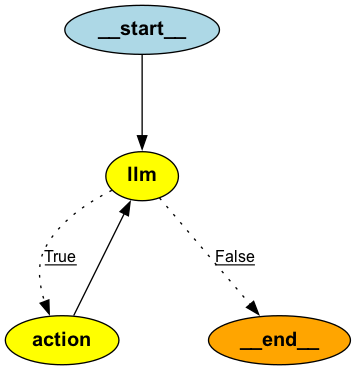

In [12]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [ ]:
abot.graph.invoke({"messages": [HumanMessage(content="")]})